In [85]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
train = pd.read_csv("../result/GSE243529/train80/dbeta_TSS_0.01.csv")
train_beta_normalized = pd.read_csv(
    "../result/GSE243529/train80/all_beta_normalized_train.csv"
)
train_beta_normalized = train_beta_normalized[
    train_beta_normalized["Unnamed: 0"].isin(train["ID"])
]

In [87]:
genes_name = train_beta_normalized.iloc[:, 0]
normal_count_train = 212
train_normal = train_beta_normalized.iloc[:, 1 : normal_count_train + 1]
train_tumor = train_beta_normalized.iloc[:, normal_count_train + 1 :]
X_train = pd.concat([train_normal, train_tumor], axis=1).T
y_train = [(0 if i < normal_count_train else 1) for i in range(X_train.shape[0])]
print(X_train.shape)
print("訓練集樣本數量: ", len(y_train))
print(
    f"訓練集中各類別樣本數量: \nnormal={normal_count_train}, tumor={X_train.shape[0]-normal_count_train}"
)

(418, 481)
訓練集樣本數量:  418
訓練集中各類別樣本數量: 
normal=212, tumor=206


In [88]:
df = pd.DataFrame(X_train)
df.columns = genes_name
df["target"] = y_train
print("原始數據集:\n", df)

原始數據集:
 Unnamed: 0  cg16264526  cg04840800  cg11147886  cg01807770  cg16688533  \
0             0.739856    0.839161    0.150897    0.835244    0.720429   
1             0.663023    0.800814    0.074663    0.889995    0.660299   
2             0.676788    0.840315    0.109436    0.847721    0.660946   
3             0.643303    0.820683    0.051006    0.867354    0.573506   
4             0.762454    0.864235    0.093466    0.862511    0.714374   
..                 ...         ...         ...         ...         ...   
413           0.717024    0.858864    0.161478    0.876126    0.721338   
414           0.672901    0.827268    0.115597    0.868650    0.679059   
415           0.679034    0.833188    0.060648    0.833572    0.336163   
416           0.707845    0.839280    0.096358    0.891187    0.735203   
417           0.754505    0.835945    0.099523    0.831909    0.724080   

Unnamed: 0  cg03023237  cg11210703  cg21290814  cg04225088  cg07157107  ...  \
0             0.791203  

In [89]:
chi2_selector = SelectKBest(chi2, k="all")
X_kbest = chi2_selector.fit_transform(X_train, y_train)

建議選擇的特徵數量: 184


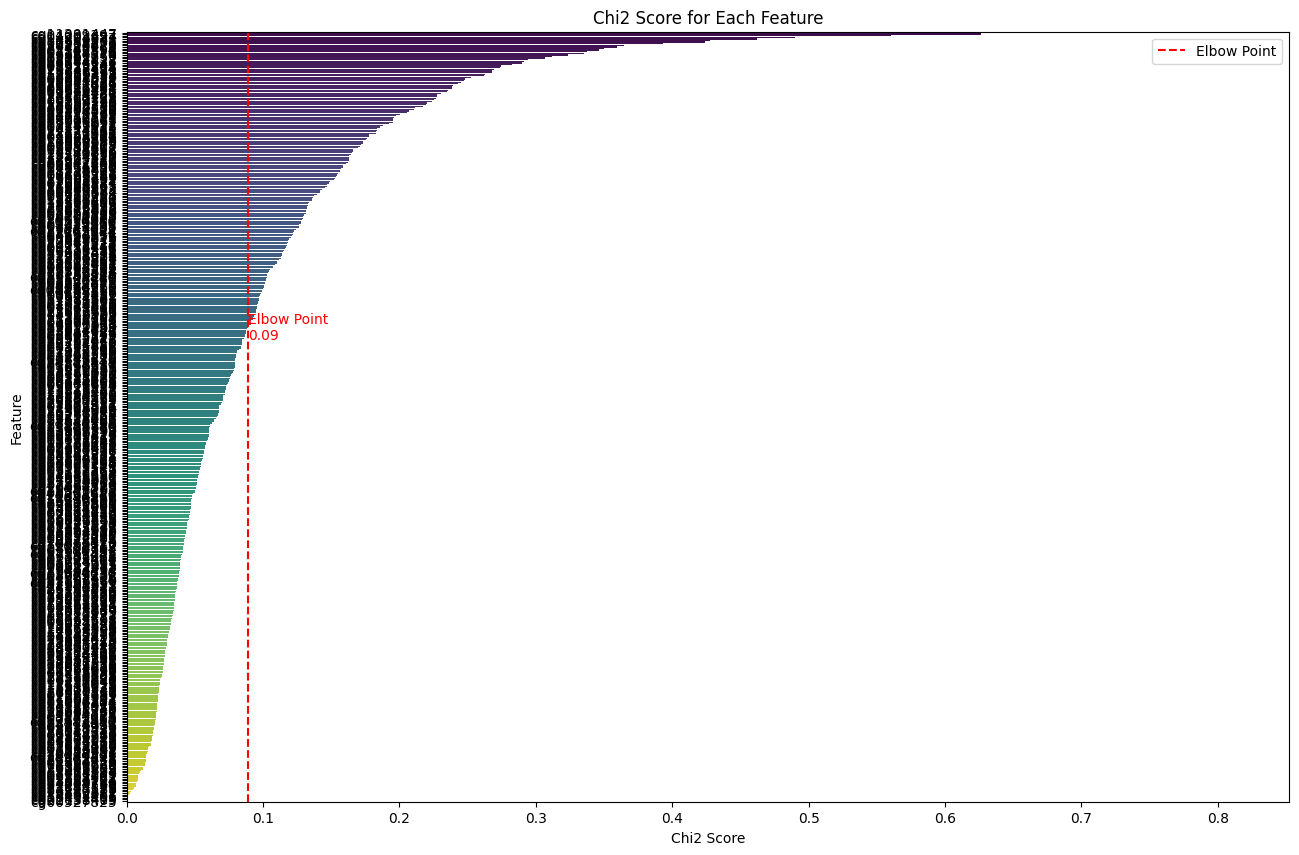

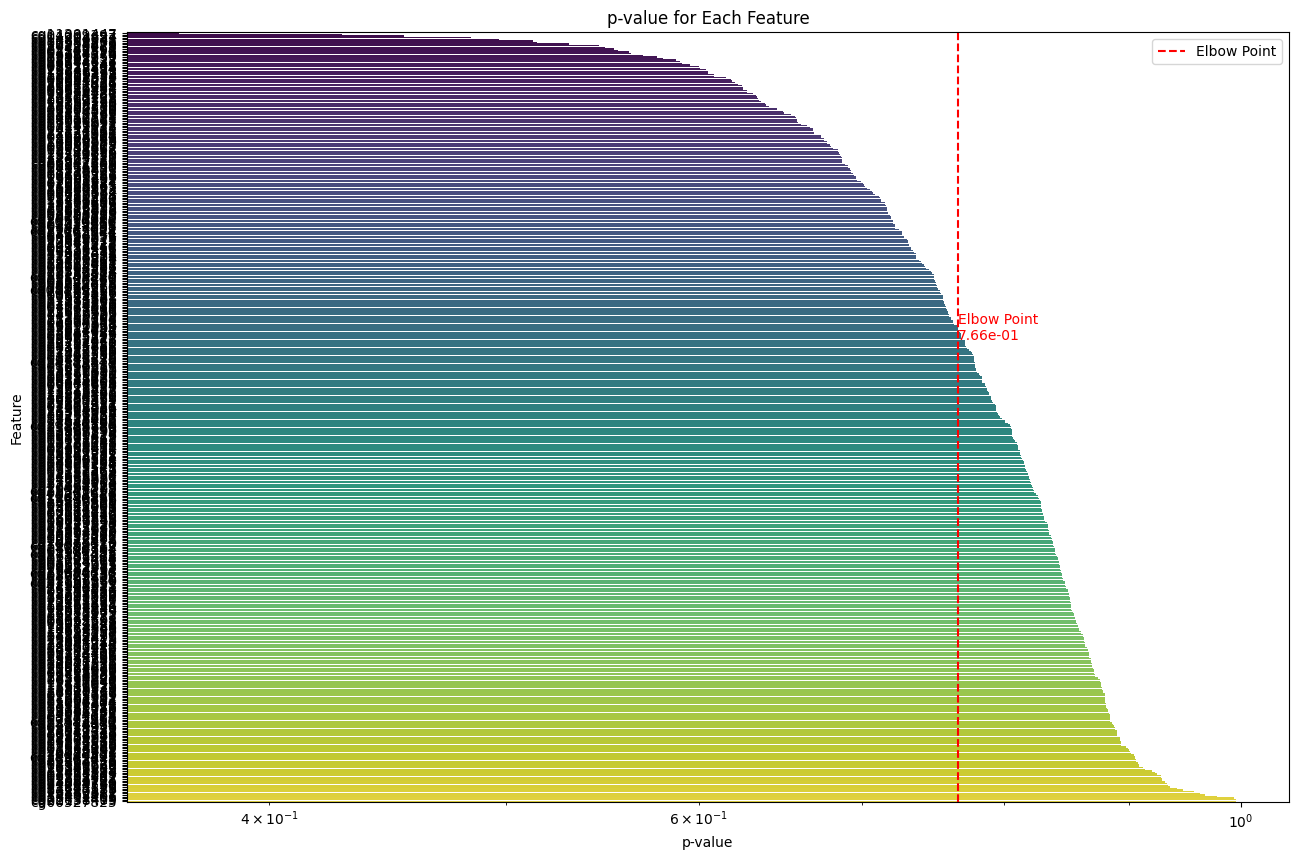

In [90]:
from kneed import KneeLocator

chi2_scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

# 方檢驗分數越高，表示該特徵與目標變量之間的相關性越強。
feature_scores = pd.DataFrame(
    {"Feature": genes_name, "Chi2 Score": chi2_scores, "p-value": p_values}
)
feature_scores_sorted = feature_scores.sort_values(by="Chi2 Score", ascending=False)
# print("按Chi2 Score排序後的特徵:\n", feature_scores_sorted)

# 使用肘部法來找到拐點
x = range(1, len(chi2_scores) + 1)
kneedle = KneeLocator(
    x,
    feature_scores_sorted["Chi2 Score"],
    online=True, #由左到右
    curve="convex",
    direction="decreasing",
)
elbow_point_index = kneedle.elbow
print(f"建議選擇的特徵數量: {elbow_point_index}")


plt.figure(figsize=(15, 10))
sns.barplot(
    x="Chi2 Score",
    y="Feature",
    data=feature_scores_sorted,
    hue="Feature",
    palette="viridis",
    legend=False,
)

plt.axvline(
    x=feature_scores_sorted.iloc[elbow_point_index]["Chi2 Score"],
    color="r",
    linestyle="--",
    label="Elbow Point",
)
plt.text(
    feature_scores_sorted.iloc[elbow_point_index]["Chi2 Score"],
    elbow_point_index,
    f'Elbow Point\n{feature_scores_sorted.iloc[elbow_point_index]["Chi2 Score"]:.2f}',
    color="r",
    ha="left",
    va="center",
)
plt.title("Chi2 Score for Each Feature")
plt.legend()
plt.show()


plt.figure(figsize=(15, 10))
sns.barplot(
    x="p-value",
    y="Feature",
    data=feature_scores_sorted,
    hue="Feature",
    palette="viridis",
    legend=False,
)
plt.axvline(
    x=feature_scores_sorted.iloc[elbow_point_index]["p-value"],
    color="r",
    linestyle="--",
    label="Elbow Point",
)
plt.text(
    feature_scores_sorted.iloc[elbow_point_index]["p-value"],
    elbow_point_index,
    f'Elbow Point\n{feature_scores_sorted.iloc[elbow_point_index]["p-value"]:.2e}',
    color="r",
    ha="left",
    va="center",
)
plt.xscale("log")
plt.title("p-value for Each Feature")
plt.legend()
plt.show()

In [92]:
chi2_selector = SelectKBest(chi2, k=elbow_point_index)
X_kbest = chi2_selector.fit_transform(X_train, y_train)

print(X_kbest.shape)

# 查看選中的特徵索引
selected_features = chi2_selector.get_support(indices=True)
selected_feature_names = [genes_name.iloc[i] for i in selected_features]
print("選中的特徵:\n", selected_feature_names)

(418, 184)
選中的特徵:
 ['cg16264526', 'cg11147886', 'cg16688533', 'cg11210703', 'cg21290814', 'cg07157107', 'cg17731992', 'cg05508558', 'cg19962750', 'cg00727675', 'cg27423177', 'cg07147033', 'cg13195526', 'cg12110437', 'cg14153654', 'cg15908975', 'cg22461018', 'cg22876908', 'cg01136458', 'cg19772011', 'cg02530321', 'cg00841151', 'cg00390253', 'cg09970481', 'cg09082617', 'cg03341469', 'cg24296478', 'cg11741201', 'cg05787952', 'cg16570507', 'cg22124136', 'cg04131610', 'cg00004996', 'cg00565412', 'cg15817960', 'cg16001977', 'cg20116935', 'cg10512376', 'cg20248866', 'cg04794887', 'cg11201654', 'cg05641529', 'cg12822818', 'cg08497766', 'cg20721738', 'cg07674238', 'cg12464820', 'cg02418535', 'cg01928820', 'cg03068068', 'cg15059851', 'cg11201447', 'cg14580628', 'cg25336198', 'cg25286393', 'cg22290284', 'cg04433322', 'cg15084269', 'cg23392390', 'cg10499172', 'cg08300899', 'cg19223467', 'cg00982519', 'cg19560758', 'cg00736523', 'cg11398323', 'cg21644856', 'cg08200293', 'cg02964724', 'cg03980224', 

In [95]:
train_chi = train[train["ID"].isin(selected_feature_names)]
train_chi.to_csv("../result/GSE243529/train80/dbeta_TSS_chi_0.01.csv", index=False)
train_chi

,ID,gene,dbeta,feature
1,cg21968765,ABI3BP,-0.012829,TSS200
2,cg10523679,ACADM,-0.015391,TSS1500
5,cg05641529,ADH1B,-0.011249,TSS1500
6,cg19245381,ADORA2B,0.010387,TSS1500
9,cg23392390,ALDH3A1,0.010933,TSS1500
...,...,...,...,...
471,cg16001977,YWHAH,0.010153,TSS200
472,cg03068068,ZBTB32,-0.013245,TSS1500
473,cg16078269,ZBTB7C,-0.010473,TSS1500
475,cg12303084,ZMYND8,-0.010327,TSS1500
